In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import corsikadata
import simple_conv_net
from tqdm.notebook import tqdm as tqdm_notebook

In [4]:
gamma_dataset = corsikadata.CorsikaData()
gamma_dataset.load("taiga607_st2b_0")

# load(gamma_dataset, "taiga607_st2b_0")

proton_dataset = corsikadata.CorsikaData()
proton_dataset.load("taiga623_st2b_0");

number of events in file: 122850
after size cut: 47109
data shape (47109, 27, 27)
labels shape (47109,)
labels[:20] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loading files done


number of events in file: 132850
after size cut: 41844
data shape (41365, 27, 27)
labels shape (41365,)
labels[:20] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
loading files done




In [5]:
input_data = np.concatenate((gamma_dataset.data, proton_dataset.data), axis=0)
input_labels = np.concatenate((gamma_dataset.labels, proton_dataset.labels), axis=0)
input_data = np.expand_dims(input_data, axis = 1)

In [6]:
input_data = np.float32(input_data)
input_labels = np.int_(input_labels)

In [7]:
rng = np.random.default_rng(42)
permut = rng.permutation(len(input_data))
input_data = input_data[permut]
input_labels = input_labels[permut]

train_portion = int(0.8 * len(input_data))

train_data = input_data[:train_portion]
train_labels = input_labels[:train_portion]
test_data = input_data[train_portion:-1]
test_labels = input_labels[train_portion:-1]

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=False, num_workers=2)
train_labels_loader = torch.utils.data.DataLoader(train_labels, batch_size=100, shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)
test_labels_loader = torch.utils.data.DataLoader(test_labels, batch_size=100, shuffle=False, num_workers=2)

In [9]:
train_data.shape

(70779, 1, 27, 27)

In [10]:
train_loader.dataset.shape

(70779, 1, 27, 27)

In [11]:
def accuracy_on_test(model, dataloader, labelsloader):
    correct = 0
    for data, labels in zip(dataloader, labelsloader):
        y_pred = net(data.to(model.device))
        y_pred = y_pred.reshape(len(labels))
        y_pred = y_pred>0.5
        c = y_pred.cpu()==labels
        correct += c.sum()
    return correct/dataloader.dataset.shape[0]

In [12]:
net = simple_conv_net.SimpleConvNet()
losses = []
accuracies = []

CNN will run on device: cuda


In [13]:
fig = plt.figure(figsize=(10,7))

<Figure size 1000x700 with 0 Axes>

  0%|          | 0/10 [00:00<?, ?it/s]

[1,   300] loss: 1.680
[1,   600] loss: 1.258


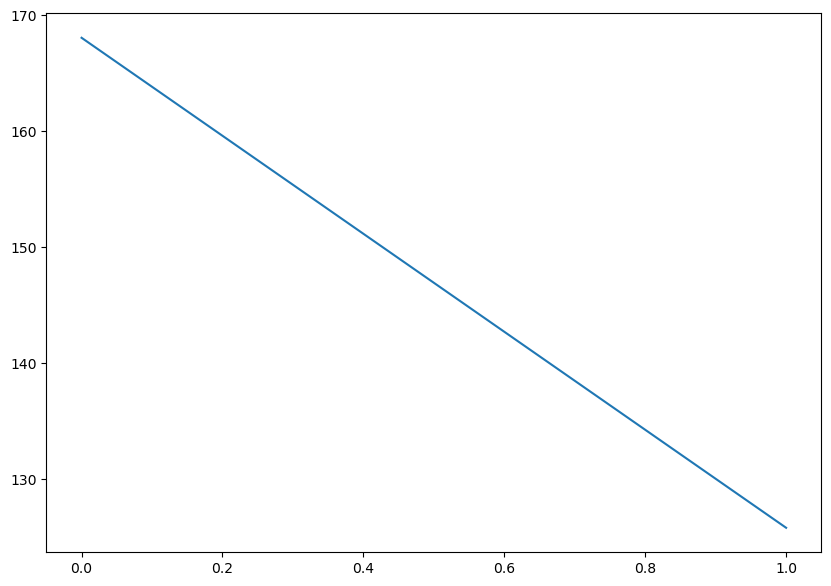

[2,   300] loss: 0.926
[2,   600] loss: 0.721
[3,   300] loss: 0.496
[3,   600] loss: 0.512
[4,   300] loss: 0.381
[4,   600] loss: 0.364
[5,   300] loss: 0.302
[5,   600] loss: 0.212
[6,   300] loss: 0.320
[6,   600] loss: 0.206
[7,   300] loss: 0.219
[7,   600] loss: 0.158
[8,   300] loss: 0.200
[8,   600] loss: 0.128
[9,   300] loss: 0.161
[9,   600] loss: 0.127
[10,   300] loss: 0.182
[10,   600] loss: 0.131
Обучение закончено


In [14]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

# итерируемся
for epoch in tqdm_notebook(range(10)):
    running_loss = 0.0
    i = 0
    for data, labels in zip(train_loader, train_labels_loader):
        net.my_optimizer.zero_grad()
        
        y_pred = net(data.to(net.device))
        y_pred = y_pred.reshape(len(labels))
        
        labels = labels.to(torch.float32)   
        y_pred = y_pred.to(torch.float32)   
        
        loss = net.my_loss_fn(y_pred, labels.to(net.device))
        loss.backward()
        net.my_optimizer.step()
        
        running_loss += loss.item()
        if i % 300 == 299:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            losses.append(running_loss)
            accuracies.append(accuracy_on_test(net, test_loader, test_labels_loader))
            running_loss = 0.0
        i+=1
    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()
print('Обучение закончено')

In [15]:
accuracy_on_test(net, train_loader, train_labels_loader)

tensor(0.9926)